## Notebook Magic

In [82]:
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [83]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve

from iefp.data import s3

In [84]:
lg = s3.read_object_from_s3("s3://iefp-unemployment/models/2019/08/15/logistic_regression_T174730.pkl")

In [85]:
rf = s3.read_object_from_s3("s3://iefp-unemployment/models/2019/08/15/random_forest_T173757.pkl")

In [86]:
gb = s3.read_object_from_s3("s3://iefp-unemployment/models/2019/08/15/gradient_boosting_T180602.pkl")

In [87]:
df_train = pd.read_parquet("s3://iefp-unemployment/models/2019/08/15/test_T174730.parquet")

In [88]:
def get_precision_recall(df_train, model):
    y = df_train["ttj_sub_12"]
    X = df_train.drop(["ttj_sub_12", "ttj"], axis='columns')
    y_prob = model.predict_proba(X)[:,1]
    precision, recall, _ = precision_recall_curve(y, y_prob)
    df_pc = pd.DataFrame([precision, recall]).T
    df_pc.columns = ["precision", "recall"]
    df_pc["recall"] = df_pc["recall"].round(3)
    df_pc = df_pc.groupby("recall").mean().reset_index()
    
    return df_pc

In [89]:
df_lg = get_precision_recall(df_train, lg)

In [90]:
df_rf = get_precision_recall(df_train, rf)

In [91]:
df_gb = get_precision_recall(df_train, gb)

In [92]:
df = df_lg.merge(df_rf, how="left", on="recall").merge(df_gb, how="left", on="recall")

In [93]:
df.columns = ["recall", "logistic regression", "random forest", "gradient boosting"]

In [102]:
df_plot = pd.melt(df, id_vars="recall", value_vars=df.columns[1:], var_name="model", value_name="precision")
df_plot = df_plot.groupby(["recall", "model"]).mean()

In [107]:
sns.set(rc={"figure.figsize": (20, 10)})
sns.set_context("paper", font_scale=3, rc={"lines.linewidth": 5, "lines.markersize": 7})
sns.set_style("white")
sns.set_style("ticks")
palette = sns.cubehelix_palette(3, start=0.9, rot=-0.8, reverse=True)
sns.set_palette(palette)

[None, None, None, None, None, None]

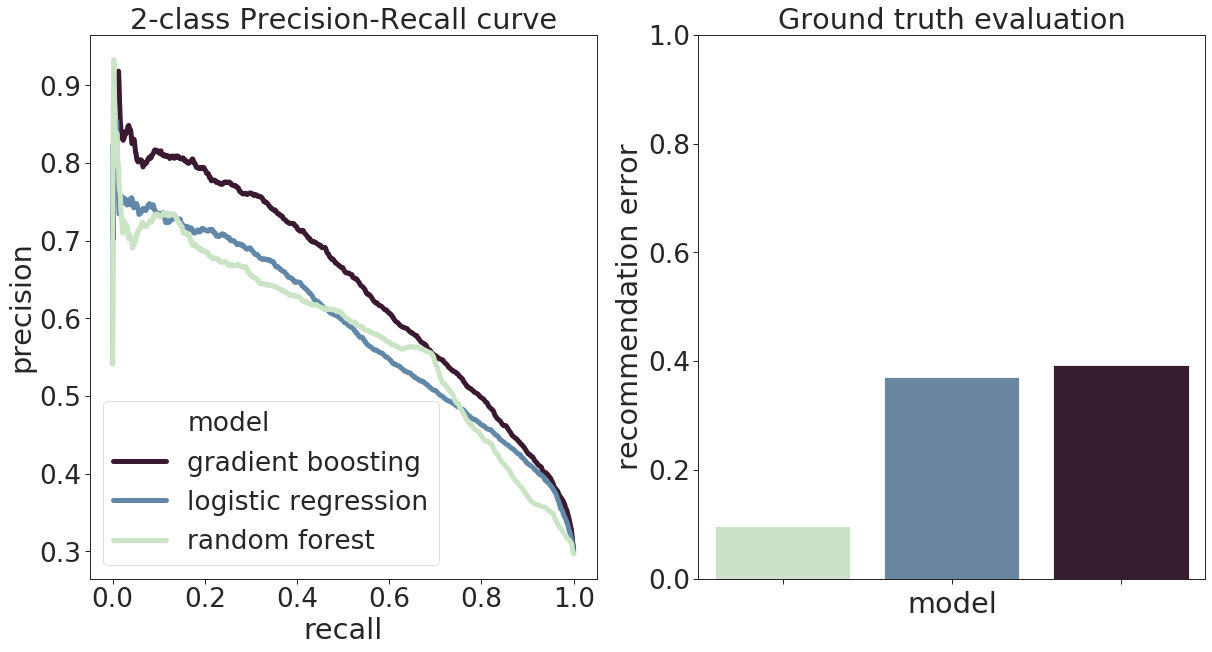

In [160]:
f, axs = plt.subplots(1, 2)

g = sns.lineplot(x="recall", y="precision", hue="model", data=df_plot.reset_index(), markers="True", ax=axs[0])
g.set_title("2-class Precision-Recall curve")

df_errors = pd.DataFrame([[0.392, 0.097, 0.37]], columns=df.columns[1:])
df_errors = df_errors.T.reset_index()
df_errors.columns = ["model", "recommendation error"]
df_errors = df_errors.sort_values("recommendation error")
g = sns.barplot(x="model", y="recommendation error", data=df_errors, palette=sns.cubehelix_palette(3, start=0.9, rot=-0.8, reverse=False), orient="v", ax=axs[1])
g.set_title("Ground truth evaluation")
g.xaxis.set_label_text("model")
g.xaxis

#ax.yaxis.set_major_locator(plt.NullLocator())
g.xaxis.set_major_formatter(plt.NullFormatter())

#plt.xticks(np.arange(0, 1.1, 0.2));
plt.yticks(np.arange(0, 1.1, 0.2));

plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=70)